In [1]:
# import modules

import csv
import numpy as np
import random

import pandas as pd
from ast import literal_eval

import sklearn
from sklearn.linear_model import LogisticRegression
import scipy
from scipy.stats.distributions import chi2

import statsmodels.api as sm
import patsy 

import researchpy as rp

import matplotlib.pyplot as plt



# Import Data 

In [2]:
# import cleaned fluency data (typos removed)
# original data (before cleaning) downloaded from https://osf.io/j6qea/ (Zemla & Austerweil, 2019)
all_ucsd_lists_table = pd.read_csv("ucsd_fluency_cleaned.csv", 
    converters={'item': eval})
all_ucsd_lists_table.head()


,id,listnum,group,SEX,EDUC,DRS,MMSE,category,rank,item
0,5,4,NC,2,16,144,30,animals,1.0,"[armadillo, horse, cow, goat, pig, rabbit, mou..."
1,6,4,NC,1,19,144,30,animals,1.0,"[mouse, rat, raccoon, dog, cat, elephant, cow,..."
2,93,1,NC,2,14,143,30,animals,1.0,"[dog, cat, ape, elephant, monkey, chimpanzee, ..."
3,93,2,NC,2,14,138,26,animals,1.0,"[owl, rhinoceros, buffalo, horse, dog, cat, el..."
4,93,3,NC,2,14,143,30,animals,1.0,"[dog, rat, camel, horse, cat, ferret, hamster,..."


In [3]:
# check how many items are not in animal category
# animals list adapted manually from https://gist.github.com/atduskgreg/3cf8ef48cb0d29cf151bedad81553a54#file-animals-txt

with open('animals_list.txt', 'r') as f:
    animal_list = [line.strip() for line in f] 
animal_list_lowercase = [str.lower(a) for a in animal_list]

not_in_animal_list = []
for i in range(len(all_ucsd_lists_table)):
    list_i=all_ucsd_lists_table.iloc[i][-1] 
    for animal_j in list_i:
        if animal_j not in animal_list_lowercase:
            not_in_animal_list += [animal_j]
print('check if you have the most updated table and animals list: ', len(not_in_animal_list)==190)


check if you have the most updated table and animals list:  True


In [4]:
# tables split by diagnosis
NC_table = all_ucsd_lists_table.loc[
    all_ucsd_lists_table['group'] == 'NC']
ProbAD_table = all_ucsd_lists_table.loc[
    all_ucsd_lists_table['group'] == 'ProbAD']

# IDs split by diagnosis
NC_ids = list(set(list(NC_table['id'])))
ProbAD_ids = list(set(list(ProbAD_table['id'])))

#Combined IDs:
NC_and_ProbAD_ids = [i for i in NC_ids if i in ProbAD_ids]


# Relevant functions for metrics and analyses 

In [5]:
def dist_from_diag_score(seqx, seqy):
    """
    calculates "distance from diagonal" score for two sequences
    ---
    Parameters:
    seqx: the first sequence (x-axis of the dot plot)
    seqx: the second sequence (y-axis of the dot plot)
    ---
    Returns:
    distance from diagonal score
    """
    seqx_noblank = [e for e in seqx if str(e)!='nan']
    seqy_noblank = [f for f in seqy if str(f)!='nan']
    dotplot = np.array(makeMatrix(seqy_noblank,seqx_noblank,1))
    score = 0
    for j in range(len(dotplot)):
        for k in range(len(dotplot[j])):
            score += dotplot[j][k]*np.abs((j+1)-(k+1))
    return score

In [6]:
def num_intrusions(list_i, category_list_of_items):
    """
    returns number of items in a list that are intrusions 
    (i.e. not in the correct category, which is also given as a list of items)
    ---
    Parameters:
    list_i: the list to check for intrusions
    dictionary_of_items: a list of items not considered in intrusions (considered correct for the category)
    """ 
    intruded_items = []
    for item in list_i:
        if item not in category_list_of_items:  #use animal_list_lowercase as dict
            intruded_items += [item]
    return len(intruded_items)
    
def num_reps(list_i):
    """
    returns number of repeated items in a list 
    ---
    Parameters:
    list_i: the list to check for repeats
    """ 
    return len(list_i)-len(set(list_i))

        
def remove_reps(seq): 
    # order preserving
    """
    removes repeated items from a list, while preserving order 
    ---
    Parameters:
    seq: the list to remove repeats from
    ---
    Returns:
    a list with any repeated instances of any values removed, preserving initial order (and 1st incidence of each item)
    """ 
    checked = []
    for e in seq:
        if e not in checked:
            checked.append(e)
    return checked


In [7]:
# basic dot plot fxns 

def delta(x,y):
    return 1 if x == y and x!= 'nan' and y!='nan' else 0

def M(seq1,seq2,i,j,k):
    return sum(delta(x,y) for x,y in zip(seq1[i:i+k],seq2[j:j+k]))

def makeMatrix(seq1,seq2,k):
    n = len(seq1)
    m = len(seq2)
    return [[M(seq1,seq2,i,j,k) for j in range(m-k+1)] for i in range(n-k+1)]

# Preparing df for analysis

In [8]:
# make table with just healthy controls (NC) & ProbAD participants, removing other diagnoses

NC_ProbAD_table = all_ucsd_lists_table[all_ucsd_lists_table['group'].isin(['NC', 'ProbAD'])]

NC_or_ProbAD_diag = []
for i in range(len(NC_ProbAD_table)):
    row_i = NC_ProbAD_table.iloc[i]
    diag_i = NC_ProbAD_table.iloc[i]['group']
    if diag_i == 'NC':
        NC_or_ProbAD_diag += [0]
    elif diag_i == 'ProbAD':
        NC_or_ProbAD_diag += [1]
    else:
        print('error: diagnosis is not NC or ProbAD')

NC_or_ProbAD_listlen = [len(NC_ProbAD_table.iloc[i]['item']) for i in range(len(NC_ProbAD_table))]
NC_ProbAD_table.insert(3, "binary_diag",NC_or_ProbAD_diag) 
NC_ProbAD_table.insert(len(NC_ProbAD_table.columns), "listlen",NC_or_ProbAD_listlen) 
print(len(NC_ProbAD_table))

NC_ProbAD_table.head()


1067


,id,listnum,group,binary_diag,SEX,EDUC,DRS,MMSE,category,rank,item,listlen
0,5,4,NC,0,2,16,144,30,animals,1.0,"[armadillo, horse, cow, goat, pig, rabbit, mou...",19
1,6,4,NC,0,1,19,144,30,animals,1.0,"[mouse, rat, raccoon, dog, cat, elephant, cow,...",22
2,93,1,NC,0,2,14,143,30,animals,1.0,"[dog, cat, ape, elephant, monkey, chimpanzee, ...",20
3,93,2,NC,0,2,14,138,26,animals,1.0,"[owl, rhinoceros, buffalo, horse, dog, cat, el...",19
4,93,3,NC,0,2,14,143,30,animals,1.0,"[dog, rat, camel, horse, cat, ferret, hamster,...",19


In [9]:
# take only the first two lists provided for everyone
# --> one entry for everyone, except if in both diagnotic groups, then get one entry per diagnosis

NC_ProbAD_table_pairedlists_rows5 = []

NC_ProbAD_table5 = NC_ProbAD_table.copy()
firstpair_done=False

for i in range(len(NC_ProbAD_table5)):
    if i<len(NC_ProbAD_table5)-1:
        row_i = NC_ProbAD_table5.iloc[i]
        next_row = NC_ProbAD_table5.iloc[i+1]
        
        id_i = row_i['id']
        id_next = next_row['id']
        
        bdiag_i = row_i['binary_diag']
        bdiag_next = next_row['binary_diag']
        
        if id_i==id_next  and  bdiag_i==bdiag_next  and  firstpair_done==False:

            list_i = row_i['item']
            list_next = next_row['item']
            
            len_i = len(list_i)
            len_next = len(list_next)
            avg_len = np.mean([len_i, len_next])
            len_diff = len_i-len_next
            
            num_intrusions_i = num_intrusions(list_i, animal_list_lowercase)
            num_intrusions_next = num_intrusions(list_next, animal_list_lowercase)
            prop_intrusions_i = num_intrusions_i/len(list_i)
            prop_intrusions_next = num_intrusions_next/len(list_next)
            
            num_reps_i = num_reps(list_i)
            num_reps_next = num_reps(list_next)
            prop_reps_i = num_reps_i/len(list_i)
            prop_reps_next = num_reps_next/len(list_next)
            
            reps_removed_i = remove_reps(list_i)
            reps_removed_next = remove_reps(list_next)
            
            avg_len_reps_removed = np.mean([len(reps_removed_i), len(reps_removed_next)])            
            
            dd_score = dist_from_diag_score(list_i, list_next)
            dd_score_reps_removed = dist_from_diag_score(reps_removed_i, reps_removed_next)
            binary_diag = bdiag_i
            rand = random.randint(0,1)
            pairedlist_table_row = [id_i, row_i['SEX'], row_i['EDUC'], 
                                    np.mean([row_i['DRS'], next_row['DRS']]),np.mean([row_i['MMSE'], next_row['MMSE']]),
                                    dd_score, np.sqrt(dd_score), dd_score**2, 
                                        avg_len, len_diff, 
                                        np.mean([prop_intrusions_i,prop_intrusions_next]), 
                                        num_intrusions_i+num_intrusions_next,
                                        np.mean([prop_reps_i, prop_reps_next]),
                                    len(reps_removed_i), len(reps_removed_next),
                                        avg_len_reps_removed,
                                        dd_score_reps_removed, np.sqrt(dd_score_reps_removed),
                                        binary_diag, rand]
            NC_ProbAD_table_pairedlists_rows5.append(pairedlist_table_row)
            firstpair_done=True 
        
        elif id_i!=id_next  or  bdiag_i!=bdiag_next:
            firstpair_done=False


                
NC_ProbAD_table_pairedlists5 = pd.DataFrame(NC_ProbAD_table_pairedlists_rows5, 
                                           columns = ['id', 'SEX', 'EDUC',
                                                      'DRS_avg', 'MMSE_avg',
                                                      'dd_score', 'sqrt_dd_score', 'dd_score^2', 
                                                      'avg_listlen','len1_minus_len2', 
                                                      'avg_prop_intrusions', 'num_intrusions',
                                                      'avg_prop_reps',
                                                      'len1_noreps', 'len2_noreps',
                                                      'avg_listlen_reps_removed',
                                                      'dd_score_reps_removed', 'sqrt_dd_score_reps_removed',
                                                      'binary_diag', 'rand_diag'])
NC_ProbAD_table_pairedlists5.head()


,id,SEX,EDUC,DRS_avg,MMSE_avg,dd_score,sqrt_dd_score,dd_score^2,avg_listlen,len1_minus_len2,avg_prop_intrusions,num_intrusions,avg_prop_reps,len1_noreps,len2_noreps,avg_listlen_reps_removed,dd_score_reps_removed,sqrt_dd_score_reps_removed,binary_diag,rand_diag
0,93,2,14,140.5,28.0,49,7.000000,2401,19.5,1,0.0,0,0.000000,20,19,19.5,49,7.000000,0,1
1,603,2,12,143.0,29.5,78,8.831761,6084,22.0,-8,0.0,0,0.000000,18,26,22.0,78,8.831761,0,0
2,610,1,12,136.0,28.5,33,5.744563,1089,16.5,3,0.0,0,0.066667,18,13,15.5,33,5.744563,0,0
3,617,1,16,136.5,29.0,53,7.280110,2809,20.0,-6,0.0,0,0.051151,16,22,19.0,46,6.782330,0,1
4,618,2,17,140.5,30.0,71,8.426150,5041,21.0,-4,0.0,0,0.026316,18,23,20.5,71,8.426150,0,0


In [10]:
# any subject with both diagnoses (healthy control/NC and ProbAD) is removed fully
NC_ProbAD_table_pairedlists5_bothdiagsremoved = NC_ProbAD_table_pairedlists5.copy()

for i in range(len(NC_ProbAD_table_pairedlists5)):
    row_i=NC_ProbAD_table_pairedlists5.iloc[i]
    id_i = row_i['id']
    diag_i = row_i['binary_diag']
    id_table = NC_ProbAD_table_pairedlists5.loc[NC_ProbAD_table_pairedlists5['id'] == id_i]
    if diag_i == 0:
        id_otherdiag = id_table.loc[id_table['binary_diag']==1]
    elif diag_i == 1: 
        id_otherdiag = id_table.loc[id_table['binary_diag']==0]
    if id_otherdiag.empty == False:
        NC_ProbAD_table_pairedlists5_bothdiagsremoved.drop(
            NC_ProbAD_table_pairedlists5_bothdiagsremoved.index[
                NC_ProbAD_table_pairedlists5_bothdiagsremoved['id'] == id_i], inplace = True)

In [11]:
# 117 subjects remain 
print(len(NC_ProbAD_table_pairedlists5_bothdiagsremoved), 'total subjects, either healthy control or ProbAD')
print(len(NC_ProbAD_table_pairedlists5_bothdiagsremoved[
    NC_ProbAD_table_pairedlists5_bothdiagsremoved['binary_diag']==0]), 
      'healthy control')
print(len(NC_ProbAD_table_pairedlists5_bothdiagsremoved[
    NC_ProbAD_table_pairedlists5_bothdiagsremoved['binary_diag']==1]), 
      'ProbAD')

117 total subjects, either healthy control or ProbAD
77 healthy control
40 ProbAD


# Demographics

### number of unique IDs (participants) total: all diagnostic groups

In [12]:
# number of participants total
len(list(set(list(all_ucsd_lists_table['id']))))

139

In [13]:
# how many subjects have both healthy control & AD diagnosis at some point?
print(len(NC_and_ProbAD_ids))

19


### number of unique IDs (subjects), by diagnostic group

In [14]:
# number of subjects per group
pivot_byGroup_IDcount_table = all_ucsd_lists_table.pivot_table(index='group', 
                                                             aggfunc=lambda x: len(x.dropna().unique()))  
# id column gives num of subjects per group
diag_table = pivot_byGroup_IDcount_table[['category','id']]

del diag_table['category']
diag_table.rename(columns={'id': 'count'})

,count
group,
AMNESTICSYNDROME,1
ATRISKFORAD,10
ATRISKFORMID,2
DLB,1
FTD,1
ImpairednoMCI,3
LEWYBODYVARNT,4
MCI,8
MCI-4a,2


### number of unique IDs, by sex (all diagnostic groups)

In [15]:
Sex1_table = all_ucsd_lists_table.loc[all_ucsd_lists_table['SEX'] == 1] #male
Sex1_IDs = list(set(list(Sex1_table['id'])))
print(len(Sex1_IDs), 'male')

Sex2_table = all_ucsd_lists_table.loc[all_ucsd_lists_table['SEX'] == 2] #female
Sex2_IDs = list(set(list(Sex2_table['id'])))
print(len(Sex2_IDs), 'female')

print(len(Sex2_IDs)/(len(Sex1_IDs)+len(Sex2_IDs))*100, '% female')

56 male
83 female
59.71223021582733 % female


### number of fluency lists, by diagnostic group

In [16]:
# total number of fluency lists
len(all_ucsd_lists_table)

1167

In [17]:
#  number of fluency lists by diagnostic group
print(len(NC_table), 'Healthy control lists')
print(len(ProbAD_table), 'ProbAD lists')
print(1167-len(NC_table )-len(ProbAD_table), 'other diagnoses lists')

785 Healthy control lists
282 ProbAD lists
100 other diagnoses lists


### demographics for sample used in analyses only 

Control and ProbAD diagnostic groups only, and only those with at least 2 fluency lists

In [18]:
# get only subjects used in analyses
print(len(set(NC_ProbAD_table_pairedlists5_bothdiagsremoved[
    NC_ProbAD_table_pairedlists5_bothdiagsremoved['binary_diag']==0]['id'])), 
      'healthy control')
print(len(set(NC_ProbAD_table_pairedlists5_bothdiagsremoved[
    NC_ProbAD_table_pairedlists5_bothdiagsremoved['binary_diag']==1]['id'])), 
      'ProbAD')

NC_used = NC_ProbAD_table_pairedlists5_bothdiagsremoved[
    NC_ProbAD_table_pairedlists5_bothdiagsremoved['binary_diag']==0]
ProbAD_used = NC_ProbAD_table_pairedlists5_bothdiagsremoved[
    NC_ProbAD_table_pairedlists5_bothdiagsremoved['binary_diag']==1]

NC_ids_used = list(NC_used['id'])
ProbAD_ids_used = list(ProbAD_used['id'])
total_ids_used = NC_ids_used+ProbAD_ids_used

NC_ProbAD_table_used_subs = NC_ProbAD_table[NC_ProbAD_table['id'].isin(total_ids_used)]


77 healthy control
40 ProbAD


mean number of timepoints: 8.042735042735043
min. number of timepoints: 2
max. number of timepoints: 26


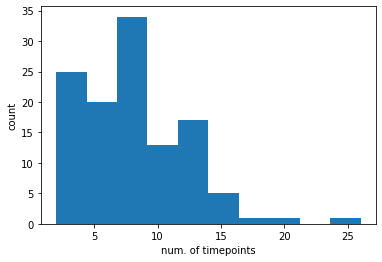

In [19]:
# number of timepoints per subject
num_timepoints_all = []
for id_i in total_ids_used:
    NC_ProbAD_table_sub_i = NC_ProbAD_table_used_subs[NC_ProbAD_table_used_subs['id']==id_i]
    num_timepoints = len(NC_ProbAD_table_sub_i)
    num_timepoints_all += [num_timepoints]

print('mean number of timepoints:', np.mean(num_timepoints_all))
print('min. number of timepoints:', np.min(num_timepoints_all))
print('max. number of timepoints:', np.max(num_timepoints_all))

plt.hist(num_timepoints_all);
plt.xlabel('num. of timepoints');
plt.ylabel('count');

In [20]:
# sex 
print('female count:',len(NC_ProbAD_table_pairedlists5_bothdiagsremoved[NC_ProbAD_table_pairedlists5_bothdiagsremoved['SEX']==2]))
print('  69/117=',69/117)
print('male count:',len(NC_ProbAD_table_pairedlists5_bothdiagsremoved[NC_ProbAD_table_pairedlists5_bothdiagsremoved['SEX']==1]))
print('  48/117=',48/117)


female count: 69
  69/117= 0.5897435897435898
male count: 48
  48/117= 0.41025641025641024


In [21]:
# MMSE score 
print('NC mean: ', np.mean(NC_used['MMSE_avg']))
print('ProbAD mean: ', np.mean(ProbAD_used['MMSE_avg']))
print('t-test: ', scipy.stats.ttest_ind(NC_used['MMSE_avg'],ProbAD_used['MMSE_avg'], equal_var=False))
rp.ttest(group1= NC_used['MMSE_avg'], group1_name= "NC",
         group2= ProbAD_used['MMSE_avg'], group2_name= "AD",
        equal_variances=False)

NC mean:  29.038961038961038
ProbAD mean:  23.8125
t-test:  Ttest_indResult(statistic=9.252875871005456, pvalue=1.3436328310345609e-12)


(   Variable      N       Mean        SD        SE  95% Conf.   Interval
 0        NC   77.0  29.038961  1.870418  0.213154  28.614428  29.463494
 1        AD   40.0  23.812500  3.308279  0.523085  22.754461  24.870539
 2  combined  117.0  27.252137  3.488666  0.322527  26.613331  27.890943,
               Welch's t-test  results
 0    Difference (NC - AD) =    5.2265
 1      Degrees of freedom =   52.2875
 2                       t =    9.2529
 3   Two side test p value =    0.0000
 4  Difference < 0 p value =    1.0000
 5  Difference > 0 p value =    0.0000
 6               Cohen's d =    1.8034
 7               Hedge's g =    1.7916
 8           Glass's delta =    2.7943
 9                       r =    0.7879)

# z-scoring IVs

In [22]:
# z-score all IVs (all metrics)
NC_ProbAD_table_zscore = NC_ProbAD_table_pairedlists5_bothdiagsremoved.copy()

NC_ProbAD_table_zscore['dd_score_z']=scipy.stats.zscore(NC_ProbAD_table_zscore['dd_score'])
NC_ProbAD_table_zscore['avg_listlen_z']=scipy.stats.zscore(NC_ProbAD_table_zscore['avg_listlen'])
NC_ProbAD_table_zscore['len1_minus_len2_z']=scipy.stats.zscore(NC_ProbAD_table_zscore['len1_minus_len2'])
NC_ProbAD_table_zscore['avg_prop_intrusions_z']=scipy.stats.zscore(NC_ProbAD_table_zscore['avg_prop_intrusions'])
NC_ProbAD_table_zscore['num_intrusions_z']=scipy.stats.zscore(NC_ProbAD_table_zscore['num_intrusions'])
NC_ProbAD_table_zscore['avg_prop_reps_z']=scipy.stats.zscore(NC_ProbAD_table_zscore['avg_prop_reps'])
NC_ProbAD_table_zscore['avg_listlen_reps_removed_z']=scipy.stats.zscore(NC_ProbAD_table_zscore['avg_listlen_reps_removed'])
NC_ProbAD_table_zscore['dd_score_reps_removed_z']=scipy.stats.zscore(NC_ProbAD_table_zscore['dd_score_reps_removed'])

NC_ProbAD_table_zscore.columns


Index(['id', 'SEX', 'EDUC', 'DRS_avg', 'MMSE_avg', 'dd_score', 'sqrt_dd_score',
       'dd_score^2', 'avg_listlen', 'len1_minus_len2', 'avg_prop_intrusions',
       'num_intrusions', 'avg_prop_reps', 'len1_noreps', 'len2_noreps',
       'avg_listlen_reps_removed', 'dd_score_reps_removed',
       'sqrt_dd_score_reps_removed', 'binary_diag', 'rand_diag', 'dd_score_z',
       'avg_listlen_z', 'len1_minus_len2_z', 'avg_prop_intrusions_z',
       'num_intrusions_z', 'avg_prop_reps_z', 'avg_listlen_reps_removed_z',
       'dd_score_reps_removed_z'],
      dtype='object')

# Logistic regression model comparisons

comparing models with and without DfD score; results summarized in Table 2.

### m1 vs. m2

In [23]:
# model 1 (m1): predicting diagnostic group (NC or ProbAD) based on
 # (1) avg_listlen_reps_removed_z: average length of the lists without repeats  
 # (2) avg_prop_reps_z: average proportion of repeats (number of repeats / length of list)

y, X = patsy.dmatrices('binary_diag ~ avg_listlen_reps_removed_z * avg_prop_reps_z', 
                       NC_ProbAD_table_zscore, 
                       return_type = 'dataframe')
model = sm.Logit(y,X)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.272075
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            binary_diag   No. Observations:                  117
Model:                          Logit   Df Residuals:                      113
Method:                           MLE   Df Model:                            3
Date:                Tue, 28 Jun 2022   Pseudo R-squ.:                  0.5764
Time:                        15:24:43   Log-Likelihood:                -31.833
converged:                       True   LL-Null:                       -75.146
Covariance Type:            nonrobust   LLR p-value:                 1.161e-18
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     -1.0622      0.376     -2.823      0.005      -1.800      -0.325
avg_listlen_reps_removed_z                    -2.6801      0.577     -4.642      0.000      -3.812      -1.549
avg_prop_reps_z                                1.5892      0.687      2.313      0.021       0.243       2.936
avg_listlen_reps_removed_z:avg_prop_reps_z     0.2517      0.997      0.253      0.801      -1.702       2.205
==============================================================================================================
"""

In [24]:
# model 2 (m2): predicting diagnostic group (NC or ProbAD) based on
 # (1) avg_listlen_reps_removed_z: average length of the lists without repeats  
 # (2) avg_prop_reps_z: average proportion of repeats (number of repeats / length of list)
 # (3) dd_score_reps_removed_z: distance from diagonal score (DfD) of the lists

y, X = patsy.dmatrices('binary_diag ~ avg_listlen_reps_removed_z * avg_prop_reps_z * dd_score_reps_removed_z', 
                       NC_ProbAD_table_zscore, 
                       return_type = 'dataframe')
model = sm.Logit(y,X)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.212517
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            binary_diag   No. Observations:                  117
Model:                          Logit   Df Residuals:                      109
Method:                           MLE   Df Model:                            7
Date:                Tue, 28 Jun 2022   Pseudo R-squ.:                  0.6691
Time:                        15:24:43   Log-Likelihood:                -24.865
converged:                       True   LL-Null:                       -75.146
Covariance Type:            nonrobust   LLR p-value:                 8.253e-19
======================================================================================================================================
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             -2.4742      0.860     -2.877      0.004      -4.160      -0.789
avg_listlen_reps_removed_z                                            -4.3639      1.529     -2.853      0.004      -7.361      -1.366
avg_prop_reps_z                                                        2.8949      1.149      2.520      0.012       0.643       5.147
avg_listlen_reps_removed_z:avg_prop_reps_z                             2.3068      2.068      1.115      0.265      -1.746       6.360
dd_score_reps_removed_z                                               -2.0738      1.135     -1.827      0.068      -4.298       0.151
avg_listlen_reps_removed_z:dd_score_reps_removed_z                    -1.5504      1.235     -1.255      0.209      -3.971       0.871
avg_prop_reps_z:dd_score_reps_removed_z                                3.1613      1.763      1.793      0.073      -0.295       6.617
avg_listlen_reps_removed_z:avg_prop_reps_z:dd_score_reps_removed_z     5.1215      2.415      2.120      0.034       0.388       9.855
======================================================================================================================================

Possibly complete quasi-separation: A fraction 0.24 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [25]:
# m1 vs. m2
# The likelihood ratio test:   
    # LR = 2*(LL(m2)-LL(m1))

L1=-31.833  #m1 is the more restrictive model
L2=-24.865  #m2 is the less restrictive model (more variables)

LR= 2*(L2-L1) 
df=7-3
print('LR:',LR) # likelihood ratio test statistic, distributed chi-squared
print(df)

p = chi2.sf(LR,df) 
print('p =','%.3g'%p) 


LR: 13.936
4
p = 0.0075


### m3 vs. m4

In [26]:
# model 3 (m3): predicting diagnostic group (NC or ProbAD) based on
 # (1) avg_listlen_reps_removed_z: average length of the lists without repeats  
 # (2) num_intrusions_z: average number of intrusions

y, X = patsy.dmatrices('binary_diag ~ avg_listlen_reps_removed_z * num_intrusions_z', 
                       NC_ProbAD_table_zscore, 
                       return_type = 'dataframe')
model = sm.Logit(y,X)
result = model.fit()
result.summary()


Optimization terminated successfully.
         Current function value: 0.240522
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            binary_diag   No. Observations:                  117
Model:                          Logit   Df Residuals:                      113
Method:                           MLE   Df Model:                            3
Date:                Tue, 28 Jun 2022   Pseudo R-squ.:                  0.6255
Time:                        15:24:43   Log-Likelihood:                -28.141
converged:                       True   LL-Null:                       -75.146
Covariance Type:            nonrobust   LLR p-value:                 3.013e-20
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -1.8990      0.496     -3.832      0.000      -2.870      -0.928
avg_listlen_reps_removed_z                     -4.0707      0.827     -4.919      0.000      -5.693      -2.449
num_intrusions_z                                1.1272      0.376      2.999      0.003       0.391       1.864
avg_listlen_reps_removed_z:num_intrusions_z     0.6892      0.573      1.202      0.229      -0.435       1.813
===============================================================================================================
"""

In [27]:
# model 4 (m4): predicting diagnostic group (NC or ProbAD) based on
 # (1) avg_listlen_reps_removed_z: average length of the lists without repeats  
 # (2) num_intrusions_z: average number of intrusions
 # (3) dd_score_reps_removed_z: distance from diagonal score (DfD) of the lists

y, X = patsy.dmatrices('binary_diag ~ avg_listlen_reps_removed_z * num_intrusions_z * dd_score_reps_removed_z', 
                       NC_ProbAD_table_zscore, 
                       return_type = 'dataframe')
model = sm.Logit(y,X)
result = model.fit()
result.summary()


Optimization terminated successfully.
         Current function value: 0.207853
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            binary_diag   No. Observations:                  117
Model:                          Logit   Df Residuals:                      109
Method:                           MLE   Df Model:                            7
Date:                Tue, 28 Jun 2022   Pseudo R-squ.:                  0.6764
Time:                        15:24:44   Log-Likelihood:                -24.319
converged:                       True   LL-Null:                       -75.146
Covariance Type:            nonrobust   LLR p-value:                 4.910e-19
=======================================================================================================================================
                                                                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                              -2.3694      0.647     -3.661      0.000      -3.638      -1.101
avg_listlen_reps_removed_z                                             -4.6622      1.273     -3.663      0.000      -7.157      -2.168
num_intrusions_z                                                        0.9180      0.605      1.518      0.129      -0.268       2.104
avg_listlen_reps_removed_z:num_intrusions_z                             1.3617      1.419      0.960      0.337      -1.419       4.143
dd_score_reps_removed_z                                                -0.0453      0.844     -0.054      0.957      -1.700       1.609
avg_listlen_reps_removed_z:dd_score_reps_removed_z                      0.1796      1.005      0.179      0.858      -1.790       2.150
num_intrusions_z:dd_score_reps_removed_z                               -1.8058      1.155     -1.563      0.118      -4.070       0.458
avg_listlen_reps_removed_z:num_intrusions_z:dd_score_reps_removed_z    -1.0539      1.992     -0.529      0.597      -4.959       2.851
=======================================================================================================================================
"""

In [28]:
# m3 vs. m4
# The likelihood ratio test:   
    # LR = 2*(LL(m2)-LL(m1))
    
L1=-28.141  #m1 is the more restrictive model
L2=-24.319  #m2 is the less restrictive model (more variables)

LR= 2*(L2-L1) 
df=7-3
print('LR:',LR) # likelihood ratio test statistic 
print(df)

p = chi2.sf(LR,df) 
print('p =','%.3g'%p) 


LR: 7.643999999999998
4
p = 0.106


### m5 vs. m6

In [29]:
# model 5 (m5): predicting diagnostic group (NC or ProbAD) based on
 # (1) avg_listlen_reps_removed_z: average length of the lists without repeats  
 # (2) len1_minus_len2_z: length difference between the two lists 
 # (3) avg_prop_reps_z: average proportion of repeats (number of repeats / length of list)
    
y, X = patsy.dmatrices('binary_diag ~ avg_listlen_reps_removed_z * len1_minus_len2_z * avg_prop_reps_z', 
                       NC_ProbAD_table_zscore, 
                       return_type = 'dataframe')
model = sm.Logit(y,X)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.257678
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            binary_diag   No. Observations:                  117
Model:                          Logit   Df Residuals:                      109
Method:                           MLE   Df Model:                            7
Date:                Tue, 28 Jun 2022   Pseudo R-squ.:                  0.5988
Time:                        15:24:44   Log-Likelihood:                -30.148
converged:                       True   LL-Null:                       -75.146
Covariance Type:            nonrobust   LLR p-value:                 1.240e-16
================================================================================================================================
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       -1.3019      0.451     -2.888      0.004      -2.185      -0.418
avg_listlen_reps_removed_z                                      -3.0452      0.707     -4.305      0.000      -4.432      -1.659
len1_minus_len2_z                                               -0.5863      0.529     -1.109      0.267      -1.623       0.450
avg_listlen_reps_removed_z:len1_minus_len2_z                    -0.6825      0.625     -1.092      0.275      -1.908       0.543
avg_prop_reps_z                                                  1.8323      0.784      2.338      0.019       0.296       3.369
avg_listlen_reps_removed_z:avg_prop_reps_z                       0.5077      1.147      0.443      0.658      -1.740       2.756
len1_minus_len2_z:avg_prop_reps_z                                0.2016      0.853      0.236      0.813      -1.470       1.873
avg_listlen_reps_removed_z:len1_minus_len2_z:avg_prop_reps_z     0.4760      1.011      0.471      0.638      -1.506       2.458
================================================================================================================================
"""

In [30]:
# model 6 (m6): predicting diagnostic group (NC or ProbAD) based on
 # (1) avg_listlen_reps_removed_z: average length of the lists without repeats  
 # (2) len1_minus_len2_z: length difference between the two lists 
 # (3) avg_prop_reps_z: average proportion of repeats (number of repeats / length of list)
 # (4) dd_score_reps_removed_z: distance from diagonal score (DfD) of the lists
    
y, X = patsy.dmatrices('binary_diag ~ avg_listlen_reps_removed_z * len1_minus_len2_z * avg_prop_reps_z * dd_score_reps_removed_z', 
                       NC_ProbAD_table_zscore, 
                       return_type = 'dataframe')

model = sm.Logit(y,X)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.186683
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            binary_diag   No. Observations:                  117
Model:                          Logit   Df Residuals:                      101
Method:                           MLE   Df Model:                           15
Date:                Tue, 28 Jun 2022   Pseudo R-squ.:                  0.7093
Time:                        15:24:44   Log-Likelihood:                -21.842
converged:                       True   LL-Null:                       -75.146
Covariance Type:            nonrobust   LLR p-value:                 7.200e-16
========================================================================================================================================================
                                                                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                               -2.7880      0.899     -3.101      0.002      -4.550      -1.026
avg_listlen_reps_removed_z                                                              -4.8469      1.914     -2.532      0.011      -8.599      -1.095
len1_minus_len2_z                                                                       -0.7934      1.018     -0.780      0.436      -2.788       1.201
avg_listlen_reps_removed_z:len1_minus_len2_z                                            -0.6631      1.186     -0.559      0.576      -2.987       1.661
avg_prop_reps_z                                                                          3.4783      1.433      2.427      0.015       0.669       6.287
avg_listlen_reps_removed_z:avg_prop_reps_z                                               0.1236      2.764      0.045      0.964      -5.294       5.541
len1_minus_len2_z:avg_prop_reps_z                                                       -3.9199      2.038     -1.924      0.054      -7.914       0.074
avg_listlen_reps_removed_z:len1_minus_len2_z:avg_prop_reps_z                            -0.5416      2.373     -0.228      0.819      -5.193       4.110
dd_score_reps_removed_z                                                                 -1.6717      1.264     -1.323      0.186      -4.149       0.806
avg_listlen_reps_removed_z:dd_score_reps_removed_z                                      -0.0435      2.164     -0.020      0.984      -4.285       4.198
len1_minus_len2_z:dd_score_reps_removed_z                                                0.3859      1.626      0.237      0.812      -2.802       3.574
avg_listlen_reps_removed_z:len1_minus_len2_z:dd_score_reps_removed_z                     1.5495      1.333      1.163      0.245      -1.062       4.161
avg_prop_reps_z:dd_score_reps_removed_z                                                  4.8247      2.433      1.983      0.047       0.057       9.593
avg_listlen_reps_removed_z:avg_prop_reps_z:dd_score_reps_removed_z                       5.3885      3.028      1.779      0.075      -0.547      11.324
len1_minus_len2_z:avg_prop_reps_z:dd_score_reps_removed_z                               -3.3822      2.978     -1.136      0.256      -9.218       2.454
avg_listlen_reps_removed_z:len1_minus_len2_z:avg_prop_reps_z:dd_score_reps_removed_z     2.5226      2.476      1.019      0.308      -2.331       7.376
========================================================================================================================================================

Possibly complete quasi-separation: A fraction 0.23 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some param

In [31]:
# m5 vs. m6
# The likelihood ratio test:   
    # LR = 2*(LL(m2)-LL(m1))
    
L1=-30.148  #m1 is the more restrictive model
L2=-21.842  #m2 is the less restrictive model (more variables)

LR= 2*(L2-L1) 
df=15-7
print('LR:',LR) # likelihood ratio test statistic 
print(df)

p = chi2.sf(LR,df) 
print('p =','%.3g'%p) 


LR: 16.612000000000002
8
p = 0.0344


### m7 vs. m8

In [32]:
# model 7 (m7): predicting diagnostic group (NC or ProbAD) based on
 # (1) len1_minus_len2_z: length difference between the two lists 
 # (2) avg_prop_reps_z: average proportion of repeats (number of repeats / length of list)

y, X = patsy.dmatrices('binary_diag ~ len1_minus_len2_z * avg_prop_reps_z', 
                       NC_ProbAD_table_zscore, 
                       return_type = 'dataframe')

model = sm.Logit(y,X)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.483367
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            binary_diag   No. Observations:                  117
Model:                          Logit   Df Residuals:                      113
Method:                           MLE   Df Model:                            3
Date:                Tue, 28 Jun 2022   Pseudo R-squ.:                  0.2474
Time:                        15:24:44   Log-Likelihood:                -56.554
converged:                       True   LL-Null:                       -75.146
Covariance Type:            nonrobust   LLR p-value:                 4.206e-08
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.6017      0.241     -2.496      0.013      -1.074      -0.129
len1_minus_len2_z                     0.1755      0.266      0.659      0.510      -0.347       0.698
avg_prop_reps_z                       1.6843      0.394      4.279      0.000       0.913       2.456
len1_minus_len2_z:avg_prop_reps_z     0.3046      0.425      0.717      0.473      -0.528       1.137
=====================================================================================================
"""

In [33]:
# model 8 (m8): predicting diagnostic group (NC or ProbAD) based on
 # (1) len1_minus_len2_z: length difference between the two lists 
 # (2) avg_prop_reps_z: average proportion of repeats (number of repeats / length of list)
 # (3) dd_score_reps_removed_z: distance from diagonal score (DfD) of the lists

y, X = patsy.dmatrices('binary_diag ~ len1_minus_len2_z * avg_prop_reps_z * dd_score_reps_removed_z', 
                       NC_ProbAD_table_zscore, 
                       return_type = 'dataframe')

model = sm.Logit(y,X)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.281400
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            binary_diag   No. Observations:                  117
Model:                          Logit   Df Residuals:                      109
Method:                           MLE   Df Model:                            7
Date:                Tue, 28 Jun 2022   Pseudo R-squ.:                  0.5619
Time:                        15:24:44   Log-Likelihood:                -32.924
converged:                       True   LL-Null:                       -75.146
Covariance Type:            nonrobust   LLR p-value:                 1.703e-15
=============================================================================================================================
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    -1.8315      0.536     -3.417      0.001      -2.882      -0.781
len1_minus_len2_z                                             0.4252      0.453      0.939      0.348      -0.462       1.313
avg_prop_reps_z                                               3.5162      1.006      3.496      0.000       1.545       5.487
len1_minus_len2_z:avg_prop_reps_z                            -0.8436      0.812     -1.039      0.299      -2.435       0.748
dd_score_reps_removed_z                                      -3.5459      0.853     -4.157      0.000      -5.218      -1.874
len1_minus_len2_z:dd_score_reps_removed_z                     0.3266      0.626      0.521      0.602      -0.901       1.554
avg_prop_reps_z:dd_score_reps_removed_z                       1.7544      1.285      1.365      0.172      -0.765       4.274
len1_minus_len2_z:avg_prop_reps_z:dd_score_reps_removed_z    -1.4570      0.978     -1.490      0.136      -3.373       0.459
=============================================================================================================================
"""

In [34]:
# m7 vs. m8
# The likelihood ratio test:   
    # LR = 2*(LL(m2)-LL(m1))
    
L1=-56.554  #m1 is the more restrictive model
L2=-32.924  #m2 is the less restrictive model (more variables)

LR= 2*(L2-L1) 
df=7-3
print('LR:',LR) # likelihood ratio test statistic 
print(df)

p = chi2.sf(LR,df) 
print('p =','%.3g'%p) 


LR: 47.260000000000005
4
p = 1.35e-09


### m9 vs. m10

In [35]:
# model 9 (m9): predicting diagnostic group (NC or ProbAD) based on
 # (1) len1_minus_len2_z: length difference between the two lists 
 # (2) num_intrusions_z: average number of intrusions

y, X = patsy.dmatrices('binary_diag ~ len1_minus_len2_z * num_intrusions_z', 
                       NC_ProbAD_table_zscore, 
                       return_type = 'dataframe')
model = sm.Logit(y,X)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.613620
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            binary_diag   No. Observations:                  117
Model:                          Logit   Df Residuals:                      113
Method:                           MLE   Df Model:                            3
Date:                Tue, 28 Jun 2022   Pseudo R-squ.:                 0.04461
Time:                        15:24:44   Log-Likelihood:                -71.794
converged:                       True   LL-Null:                       -75.146
Covariance Type:            nonrobust   LLR p-value:                   0.08191
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -0.6724      0.201     -3.342      0.001      -1.067      -0.278
len1_minus_len2_z                      0.0788      0.207      0.381      0.704      -0.327       0.485
num_intrusions_z                       0.5035      0.212      2.372      0.018       0.087       0.920
len1_minus_len2_z:num_intrusions_z    -0.1365      0.163     -0.839      0.401      -0.455       0.182
======================================================================================================
"""

In [36]:
# model 10 (m10): predicting diagnostic group (NC or ProbAD) based on
 # (1) len1_minus_len2_z: length difference between the two lists 
 # (2) num_intrusions_z: average number of intrusions
 # (3) dd_score_reps_removed_z: distance from diagonal score (DfD) of the lists
y, X = patsy.dmatrices('binary_diag ~ len1_minus_len2_z * num_intrusions_z * dd_score_reps_removed_z', 
                       NC_ProbAD_table_zscore, 
                       return_type = 'dataframe')

model = sm.Logit(y,X)
result = model.fit()
result.summary()


Optimization terminated successfully.
         Current function value: 0.385053
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            binary_diag   No. Observations:                  117
Model:                          Logit   Df Residuals:                      109
Method:                           MLE   Df Model:                            7
Date:                Tue, 28 Jun 2022   Pseudo R-squ.:                  0.4005
Time:                        15:24:44   Log-Likelihood:                -45.051
converged:                       True   LL-Null:                       -75.146
Covariance Type:            nonrobust   LLR p-value:                 1.383e-10
==============================================================================================================================
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                     -1.8305      0.467     -3.922      0.000      -2.745      -0.916
len1_minus_len2_z                                              0.7824      0.393      1.992      0.046       0.013       1.552
num_intrusions_z                                               0.6239      0.331      1.885      0.059      -0.025       1.272
len1_minus_len2_z:num_intrusions_z                             0.1640      0.353      0.464      0.643      -0.529       0.857
dd_score_reps_removed_z                                       -3.2240      0.693     -4.655      0.000      -4.582      -1.867
len1_minus_len2_z:dd_score_reps_removed_z                      0.8316      0.456      1.824      0.068      -0.062       1.725
num_intrusions_z:dd_score_reps_removed_z                      -0.3801      0.759     -0.501      0.617      -1.868       1.108
len1_minus_len2_z:num_intrusions_z:dd_score_reps_removed_z    -0.3792      0.319     -1.189      0.234      -1.004       0.246
==============================================================================================================================
"""

In [37]:
# m9 vs. m10
# The likelihood ratio test:   
    # LR = 2*(LL(m2)-LL(m1))
    
L1=-71.794  #m1 is the more restrictive model
L2=-45.051  #m2 is the less restrictive model (more variables)

LR= 2*(L2-L1) 
df=7-3
print('LR:',LR) # likelihood ratio test statistic 
print(df)

p = chi2.sf(LR,df) 
print('p =','%.3g'%p) 

LR: 53.48599999999999
4
p = 6.74e-11


# Comparing metrics btwn NC & ProbAD (t-tests)

### distance from diagonal (DfD) score

In [38]:
NC_dd_scores=[]
AD_dd_scores=[]
for i in range(len(NC_ProbAD_table_pairedlists5_bothdiagsremoved)):
    row=NC_ProbAD_table_pairedlists5_bothdiagsremoved.iloc[i]
    if row['binary_diag']==0:
        NC_dd_scores+=[row['dd_score_reps_removed']]
    elif row['binary_diag']==1:
        AD_dd_scores+=[row['dd_score_reps_removed']]
        
print('mean control score:', np.mean(NC_dd_scores))
print('mean ProbAD score:', np.mean(AD_dd_scores))
print('t-test:', scipy.stats.ttest_ind(NC_dd_scores,AD_dd_scores, equal_var=False))
df_rp = NC_ProbAD_table_pairedlists5_bothdiagsremoved.copy()
rp.ttest(group1= df_rp['dd_score_reps_removed'][df_rp['binary_diag'] == 0], group1_name= "NC",
         group2= df_rp['dd_score_reps_removed'][df_rp['binary_diag'] == 1], group2_name= "AD",
        equal_variances=False)


mean control score: 43.532467532467535
mean ProbAD score: 14.525
t-test: Ttest_indResult(statistic=7.925084041267242, pvalue=1.9934586232629897e-12)


(   Variable      N       Mean         SD        SE  95% Conf.   Interval
 0        NC   77.0  43.532468  27.987584  3.189481  37.180065  49.884870
 1        AD   40.0  14.525000  11.356660  1.795646  10.892964  18.157036
 2  combined  117.0  33.615385  27.340713  2.527650  28.609056  38.621714,
               Welch's t-test   results
 0    Difference (NC - AD) =    29.0075
 1      Degrees of freedom =   110.2322
 2                       t =     7.9251
 3   Two side test p value =     0.0000
 4  Difference < 0 p value =     1.0000
 5  Difference > 0 p value =     0.0000
 6               Cohen's d =     1.5446
 7               Hedge's g =     1.5345
 8           Glass's delta =     1.0364
 9                       r =     0.6025)

### average length of list score (with repeats removed)

In [39]:
# avg listlen (reps removed); for list pairs 
NC_avg_listlen=[]
AD_avg_listlen=[]
for i in range(len(NC_ProbAD_table_pairedlists5_bothdiagsremoved)):
    row=NC_ProbAD_table_pairedlists5_bothdiagsremoved.iloc[i]
    if row['binary_diag']==0:
        NC_avg_listlen+=[row['avg_listlen_reps_removed']]
    elif row['binary_diag']==1:
        AD_avg_listlen+=[row['avg_listlen_reps_removed']]
        
print('mean control score:', np.mean(NC_avg_listlen))
print('mean ProbAD score:', np.mean(AD_avg_listlen))
# print(len(NC_avg_listlen))
# print(len(AD_avg_listlen))
print('t-test:', scipy.stats.ttest_ind(NC_avg_listlen, AD_avg_listlen, equal_var=False))
df_rp = NC_ProbAD_table_pairedlists5_bothdiagsremoved.copy()
rp.ttest(group1= df_rp['avg_listlen_reps_removed'][df_rp['binary_diag'] == 0], group1_name= "NC",
         group2= df_rp['avg_listlen_reps_removed'][df_rp['binary_diag'] == 1], group2_name= "AD",
        equal_variances=False)


mean control score: 19.551948051948052
mean ProbAD score: 12.5375
t-test: Ttest_indResult(statistic=10.08910693364162, pvalue=1.7283579962725939e-15)


(   Variable      N       Mean        SD        SE  95% Conf.   Interval
 0        NC   77.0  19.551948  3.353694  0.382189  18.790753  20.313143
 1        AD   40.0  12.537500  3.673166  0.580779  11.362765  13.712235
 2  combined  117.0  17.153846  4.803223  0.444058  16.274333  18.033359,
               Welch's t-test  results
 0    Difference (NC - AD) =    7.0144
 1      Degrees of freedom =   73.0605
 2                       t =   10.0891
 3   Two side test p value =    0.0000
 4  Difference < 0 p value =    1.0000
 5  Difference > 0 p value =    0.0000
 6               Cohen's d =    1.9664
 7               Hedge's g =    1.9535
 8           Glass's delta =    2.0916
 9                       r =    0.7630)

### repetitions score: proportion of items in a list that are repeated 

In [40]:
NC_avg_prop_reps=[]
AD_avg_prop_reps=[]
for i in range(len(NC_ProbAD_table_pairedlists5_bothdiagsremoved)):
    row=NC_ProbAD_table_pairedlists5_bothdiagsremoved.iloc[i]
    if row['binary_diag']==0:
        NC_avg_prop_reps+=[row['avg_prop_reps']]
    elif row['binary_diag']==1:
        AD_avg_prop_reps+=[row['avg_prop_reps']]
        
print('mean control score:', np.mean(NC_avg_prop_reps))
print('mean ProbAD score:', np.mean(AD_avg_prop_reps))
print('t-test:', scipy.stats.ttest_ind(NC_avg_prop_reps, AD_avg_prop_reps, equal_var=False))
df_rp = NC_ProbAD_table_pairedlists5_bothdiagsremoved.copy()
rp.ttest(group1= df_rp['avg_prop_reps'][df_rp['binary_diag'] == 0], group1_name= "NC",
         group2= df_rp['avg_prop_reps'][df_rp['binary_diag'] == 1], group2_name= "AD",
        equal_variances=False)


mean control score: 0.019873185499442378
mean ProbAD score: 0.09032900478565271
t-test: Ttest_indResult(statistic=-5.034902544868928, pvalue=9.007742547492986e-06)


(   Variable      N      Mean        SD        SE  95% Conf.  Interval
 0        NC   77.0  0.019873  0.027123  0.003091   0.013717  0.026029
 1        AD   40.0  0.090329  0.086316  0.013648   0.062724  0.117934
 2  combined  117.0  0.043961  0.064136  0.005929   0.032217  0.055705,
               Welch's t-test  results
 0    Difference (NC - AD) =   -0.0705
 1      Degrees of freedom =   43.0455
 2                       t =   -5.0349
 3   Two side test p value =    0.0000
 4  Difference < 0 p value =    0.0000
 5  Difference > 0 p value =    1.0000
 6               Cohen's d =   -0.9813
 7               Hedge's g =   -0.9749
 8           Glass's delta =   -2.5976
 9                       r =    0.6088)

### number of intrusions

In [41]:
NC_num_intrusions=[]
AD_num_intrusions=[]
for i in range(len(NC_ProbAD_table_pairedlists5_bothdiagsremoved)):
    row=NC_ProbAD_table_pairedlists5_bothdiagsremoved.iloc[i]
    if row['binary_diag']==0:
        NC_num_intrusions+=[row['num_intrusions']]
    elif row['binary_diag']==1:
        AD_num_intrusions+=[row['num_intrusions']]
        
print('mean control score:', np.mean(NC_num_intrusions))
print('mean ProbAD score:', np.mean(AD_num_intrusions))
print('t-test:',scipy.stats.ttest_ind(NC_num_intrusions, AD_num_intrusions, equal_var=False))
df_rp = NC_ProbAD_table_pairedlists5_bothdiagsremoved.copy()
rp.ttest(group1= df_rp['num_intrusions'][df_rp['binary_diag'] == 0], group1_name= "NC",
         group2= df_rp['num_intrusions'][df_rp['binary_diag'] == 1], group2_name= "AD",
        equal_variances=False)

mean control score: 0.14285714285714285
mean ProbAD score: 0.4
t-test: Ttest_indResult(statistic=-2.134201768764779, pvalue=0.037614602269847794)


(   Variable      N      Mean        SD        SE  95% Conf.  Interval
 0        NC   77.0  0.142857  0.387783  0.044192   0.054841  0.230873
 1        AD   40.0  0.400000  0.708918  0.112090   0.173277  0.626723
 2  combined  117.0  0.230769  0.531501  0.049137   0.133447  0.328092,
               Welch's t-test  results
 0    Difference (NC - AD) =   -0.2571
 1      Degrees of freedom =   51.4288
 2                       t =   -2.1342
 3   Two side test p value =    0.0376
 4  Difference < 0 p value =    0.0188
 5  Difference > 0 p value =    0.9812
 6               Cohen's d =   -0.4160
 7               Hedge's g =   -0.4132
 8           Glass's delta =   -0.6631
 9                       r =    0.2852)